Image Shape: (685, 1024, 3) , Image Size: 2104320


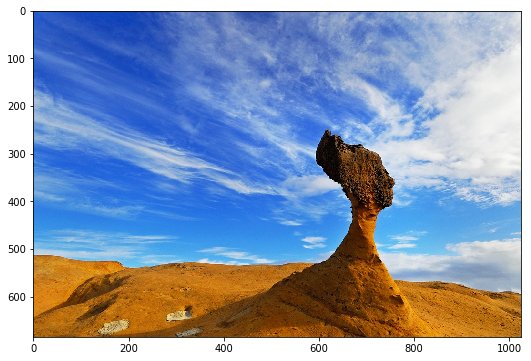

0


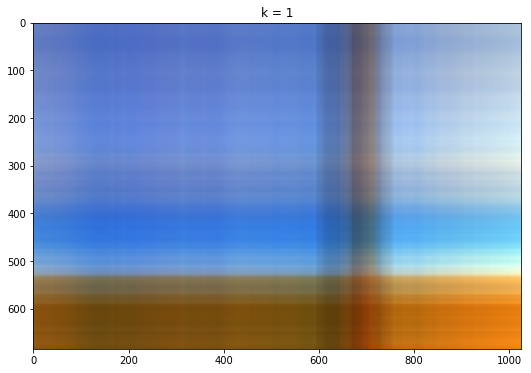

2-Norm: 19864.9606, sigma(k+1): 19864.9606
PSNR: 16.5766
compressed size: 5130, original size: 2104320, Space savings: 99.76%, Compression Ratio: 410.20


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2

# img in GBR order same as OpenCV
def showPlt(img, title=""):
    im2 = img
    if im2.ndim == 3:
        im2 = im2[:,:,::-1]  # 轉 RGB Order
    plt.figure(figsize=(9, 6))
#     plt.imshow(im2);
    plt.imshow(im2.astype(np.uint8));
    plt.title(title)
    plt.show()    

# 以前 k 個 sigma 重組影單一 channel 影像. U,S,V為單一channel影像的SVD拆解。
def reconstructChannel(U, S, V, k):
    reconstChannel = np.matrix(U[:, :k+1]) * np.diag(S[:k+1]) * np.matrix(V[:k+1, :])
    return reconstChannel

# 傳入k, 三次迴圈重組 RGB 3個 channel的影像後，合成彩色影像(reconstimg).
def reconstructImage(shape, aU, aS, aV, k):
    reconstimg = np.zeros(shape)  #initial變數，用來存重組的彩色影像
    
    for i in range(3):
        reconstimg[:,:,i] = reconstructChannel(aU[:,:,i], aS[:,i], aV[:,:,i], k)  #分別重組RGB channel
        
    compression_size = aU[:,:k+1,:].size + aV[:k+1,:,:].size + aS[:k+1,:].size  #壓縮後的size, (U(mxk) + S(kxk) + V(kxn))*3   
    cumulative_proportion = np.sum(np.power(aS[:k+1,0], 2)) / np.sum(np.power(aS[:,0], 2))  #Variance累加貢獻比率
    sigmaF2 = np.sum(np.power(aS[k+1:,0], 2))  #計算 k+1~p 的 sigma平方和，檢查其值必須與 F norm 的平方相等，9/23上課筆記
    
    return reconstimg, compression_size, cumulative_proportion, sigmaF2


# 處理重組時爆掉，即pixel value < 0 or value > 255，
# pixel value 小於0時，取絕對值。pixel value大於 255 值，設為255。
# 處理只是為了顯示，在計算 norm 時，不可以用調整過的值算，否則會與 sigma k+1 不相等。
def processExplosion(reconstimg):
    imgToShow = np.copy(reconstimg)
    # 處理爆掉，value < 0 or value > 255
    for j in range(3):
        ab = imgToShow[:,:,j] < 0
        ab = ab.astype(int) * -1
        ab[ab == 0] = 1
        imgToShow[:,:,j] = imgToShow[:,:,j] * ab
    imgToShow[imgToShow > 255] = 255
    return imgToShow

#計算 2-norm
def norm2(img1, img2):
    diff = img1 - img2
    return np.linalg.norm(diff, 2)

#計算 F-norm 的平方
def normFrobeniusSquared(img1, img2):
    diff = img1 - img2
    return np.linalg.norm(diff, 'fro') ** 2

def psnr(img1, img2):
    mse = np.mean( (img1/1. - img2/1.) ** 2 )
#     mse = np.mean( (img1/255. - img2/255.) ** 2 )
    if mse < 1.0e-10:
       return 100
    PIXEL_MAX = 255
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def psnr2(img1, img2):
#     print('img1 max: ', np.amax(img1), 'img1 min: ', np.amin(img1))
#     print('img2 max: ', np.amax(img2), 'img2 min: ', np.amin(img2))
    mse = np.mean( (img1/1. - img2/1.) ** 2 )
#     mse = np.mean( diff )
    sumEle = np.sum((img1/1. - img2/1.) ** 2)
#     sumEle = np.sum( diff )
    mse2 = sumEle / (img1.shape[0] * img1.shape[1] * img1.shape[2])
#     print(mse, mse2)
    PIXEL_MAX = 255
#     psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    psnr = 20 * math.log10(PIXEL_MAX) - 10 *  math.log10(math.sqrt(mse2))
    return psnr

def psnr3(image1, image2):
    # OpenCV
#     print('OpenCV PSNR: ', cv2.PSNR(image1, image2))
    return cv2.PSNR(image1, image2)

def psnr4(image1, image2):
    # Own implementation
    mse = np.mean((image1.astype(np.float64) / 255 - image2.astype(np.float64) / 255) ** 2)
    psnr = 10 * np.log10(1. / mse)
#     print('Own implementation: ', psnr)
    return psnr

def calculate_psnr(s, r):
    height, width, channel = s.shape
    size = height * width

    sb,sg,sr = cv2.split(s)
    rb,rg,rr = cv2.split(r)

    mseb = ((sb-rb)**2).sum()
    mseg = ((sg-rg)**2).sum()
    mser = ((sr-rr)**2).sum()

    MSE = (mseb+mseg+mser)/(3*size)
    psnr = 10*math.log10(255**2/MSE)
    return round(psnr,2)

# 主流程
def main(img_file):
    
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)  #讀影像檔
    img = img.astype(np.float64)   #uint8轉float
    print('Image Shape:', img.shape, ', Image Size:', img.size)
    showPlt(img)

    # BGR Order: show B, G, R images
#     for i in range(3):
#         showPlt(img[:,:,i])  #分別show出 3 個 channel

    # aU, aS, aV，以儲存3個channel的 U, Sigma, V
    aU = np.zeros((img.shape[0], img.shape[0], 3))
    aS = np.zeros((min([img.shape[0], img.shape[1]]), 3))
    aV = np.zeros((img.shape[1], img.shape[1], 3))

#     print(aU[0].shape)
#     print(aS[0].shape)
#     print(aV[0].shape)
    
    # channel in BGR Order
    for channel in range(3):
        U, sigma, V = np.linalg.svd(img[:,:,channel])    # 分別對3個channel作 SVD 分解
        aU[:,:,channel] = U
        aS[:,channel] = sigma
        aV[:,:,channel] = V
        
#         print("U Shape:", U.shape)
#         print("Sigma Shape:", sigma.shape)
#         print("V Shape:", V.shape)

#         if channel == 0:
#             print(sigma)  #印B channel拆解的 sigma 看一下
    
        # 驗證 U, V 是否是 othogonal, 與自己的轉置相乘 = 單位矩陣
        # print(sigma)
#         othogonal = np.dot(U, U.transpose())
#         print(othogonal)
#         print(np.inner(U[:,4], U[:,10]))
#         othogonal = np.dot(V, V.transpose())
#         print(othogonal)
#         print(np.inner(V[:,32], V[:,54]))

    step = 5
    # 重組影像, k=1，k=2, ..., k=p=長或寬小的那一個, step=1
#     for k in range(0, min([img.shape[0], img.shape[1]]), step):
    for k in range(0, 1, 1):
        reconstimg, reconstSize, cumulative_proportion, sigmaF2 = reconstructImage((img.shape[0], img.shape[1], 3), aU, aS, aV, k)
#         imgtoshow = reconstimg

        imgtoshow = processExplosion(reconstimg)

        # 寫出重組的影像檔案
        print(k)
#         cv2.imwrite('web/images/queen/images_' + str(k+1) + '.png', imgtoshow)

        # 顯示重組的影像
        title = "k = %s" % (k+1)
        showPlt(imgtoshow, title)  

        # 檢查 2-norm與sigma k+1是否相等，參考上課筆記9/23
        if k != min([img.shape[0], img.shape[1]])-1:   # 最後一筆的k+1 index 就超過了
            print('2-Norm: %.4f, sigma(k+1): %.4f' % (norm2(img[:,:,0], reconstimg[:,:,0]), aS[:,0][k+1]) )

        # 印出 PSNR
        print('PSNR: %.4f' % (psnr4(img, imgtoshow)))
        # 印出壓縮比
        print('compressed size: %d, original size: %d, Space savings: %.2f%%, Compression Ratio: %.2f' % (reconstSize, img.size, 100-reconstSize/img.size*100, img.size/reconstSize))

        # 寫出 html 網頁用的表格資料
        # html 的 norm_sigmak1_psnr 變數表格
#         sigma = 'null'
#         if k < min([img.shape[0], img.shape[1]])-1:
#             sigma = format(aS[:,0][k+1], '.4f')
#         print( '[%d, %.4f, %s, %.2f, %.4f, %.4f, %.4f], ' % (k+1, norm2(img[:,:,0], reconstimg[:,:,0]), sigma, psnr4(img.astype(np.uint8), imgtoshow.astype(np.uint8)), cumulative_proportion, normFrobeniusSquared(img[:,:,0], reconstimg[:,:,0]), sigmaF2 )  )  # print norm2, sigma_k+1, PSNR, cumulative_proportion

        # 寫出 html 網頁用的 Google Chart 表格資料
#         print( '[%d, %.4f, null],' % (k+1, aS[:,0][k]) )  # print sigma
#         print( '[%d, %.2f, null], ' % (k+1, img.size/reconstSize ) )  # print k, compression ratio壓縮比.  #計算壓縮比 Compression Ratio, 參考 https://en.wikipedia.org/wiki/Data_compression_ratio
#         print( '[%d, %.2f, null], ' % (k+1, psnr4(img.astype(np.uint8), imgtoshow.astype(np.uint8) ) ) )  # print k, PSNR


folder = 'source_images'        
main(folder + '/queen1.jpg')
# main('queen2.jpg')
# main('tunghai_church.jpg')
# main('tunghai_church_2.jpg')
# main('tunghai_church_3.jpg')
# main('boat.tif')



In [22]:
!pip list

Package                            Version   
---------------------------------- ----------
absl-py                            0.7.1     
alabaster                          0.7.12    
anaconda-client                    1.7.2     
anaconda-navigator                 1.9.12    
anaconda-project                   0.8.2     
applaunchservices                  0.2.1     
appnope                            0.1.0     
appscript                          1.0.1     
argh                               0.26.2    
asn1crypto                         0.24.0    
astor                              0.8.0     
astroid                            2.2.5     
astropy                            3.1.2     
atomicwrites                       1.3.0     
attrs                              19.1.0    
autopep8                           1.4.4     
Babel                              2.6.0     
backcall                           0.1.0     
backports.os                       0.1.1     
backports.shutil-get-terminal-size